# Setup

Import libraries and load data:

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

# Load Fashion MNIST dataset:
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize images:
train_images, test_images = (x / 255.0 for x in (train_images, test_images))


class Constants:
    class_names = [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]
    number_of_classes = len(class_names)
    image_shape = train_images[0].shape + (1,)

Model = namedtuple("Model", ["name", "nn"])


Models to compare:

In [9]:
def simple_cnn(kernel_size: int) -> tf.keras.Sequential:
    return tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                64,
                kernel_size=(kernel_size, kernel_size),
                activation="relu",
                kernel_initializer="he_normal",
                input_shape=Constants.image_shape,
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(Constants.number_of_classes),
        ]
    )


def mult_layer_cnn() -> tf.keras.Sequential:
    return tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                32,
                kernel_size=(3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                input_shape=Constants.image_shape,
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(
                64,
                kernel_size=(3, 3),
                activation="relu",
                kernel_initializer="he_normal",
                input_shape=Constants.image_shape,
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(Constants.number_of_classes),
        ]
    )


models = [
    Model(
        "simple_mlp",
        tf.keras.Sequential(
            [
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(Constants.number_of_classes),
            ]
        ),
    ),
    Model("simple_cnn_3", simple_cnn(3)),
    Model("simple_cnn_5", simple_cnn(5)),
    Model("mult_layer_cnn", mult_layer_cnn()),
]


# Model training

In [10]:
def compile_and_train(model: tf.keras.Sequential, epochs: int = 3):
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    model.fit(train_images, train_labels, epochs=epochs)


for model in models:
    print(f"\nTraining {model.name}")
    compile_and_train(model.nn)



Training simple_mlp
Epoch 1/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5020 - accuracy: 0.8243
Epoch 2/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3765 - accuracy: 0.8638
Epoch 3/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3364 - accuracy: 0.8779

Training simple_cnn_3
Epoch 1/3
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3950 - accuracy: 0.8616
Epoch 2/3
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2509 - accuracy: 0.9090
Epoch 3/3
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2047 - accuracy: 0.9243

Training simple_cnn_5
Epoch 1/3
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3886 - accuracy: 0.8619
Epoch 2/3
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2567 - accuracy: 0.9042
Epoch 3/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2121 - accuracy: 0.9210

Training mult_lay

# Illustrtrating the Prediction Instability

In [11]:
def show_image(image: np.array, label: str):
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label)


def plot_predictions_array(prediction: np.array, true_label: int):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    plot = plt.bar(range(10), prediction, color="#777777")
    plt.ylim([0, 1])
    plot[np.argmax(prediction)].set_color("red")
    plot[true_label].set_color("blue")


def plot_image_w_predictions(image: np.array, prediction: np.array, true_label: int):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    show_image(
        image,
        f"{Constants.class_names[np.argmax(prediction)]} {np.max(prediction):.2f} ({Constants.class_names[true_label]})",
    )
    plt.subplot(1, 2, 2)
    plot_predictions_array(prediction, true_label)
    plt.show()


def predict_and_plot(model: tf.keras.Sequential, images: np.array, true_label: int):
    probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    predictions = probability_model.predict(images, verbose=0)
    for i, prediction in enumerate(predictions):
        plot_image_w_predictions(images[i], prediction, true_label)


Shifting the image changes the prediction:


Plots for simple_mlp


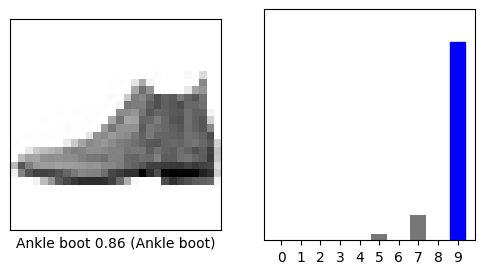

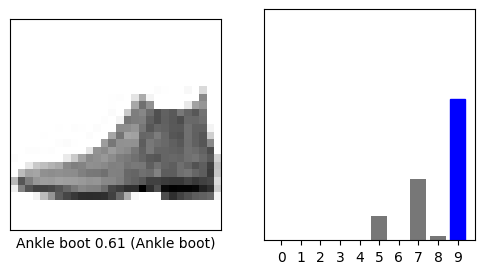

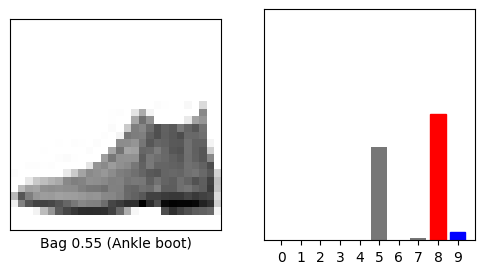


Plots for simple_cnn_3


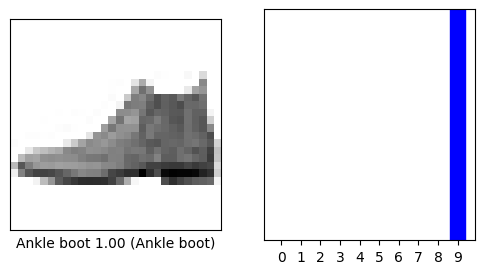

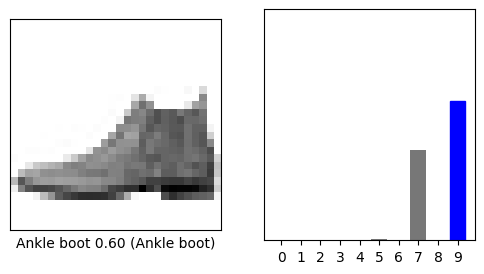

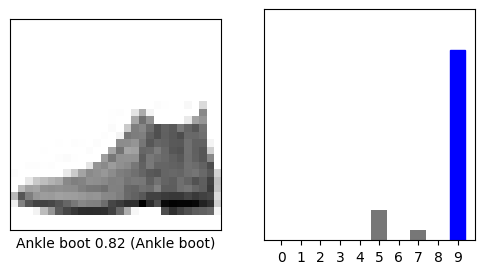


Plots for simple_cnn_5


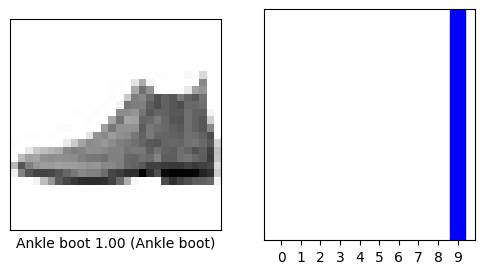

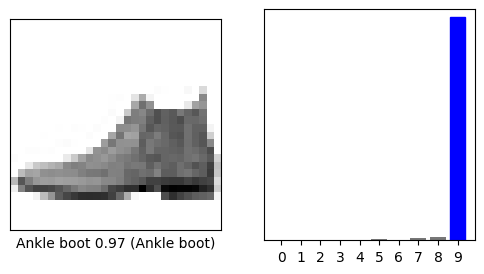

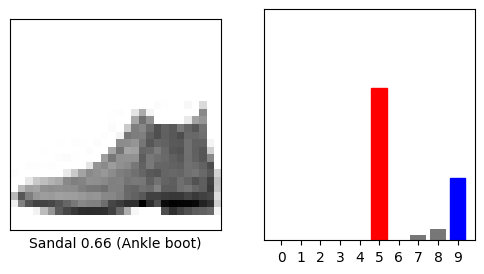


Plots for mult_layer_cnn


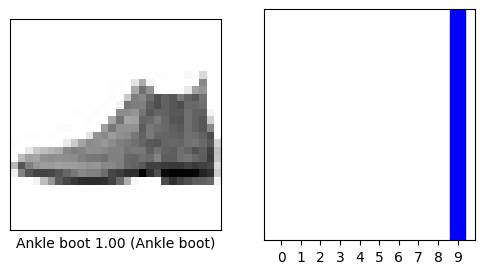

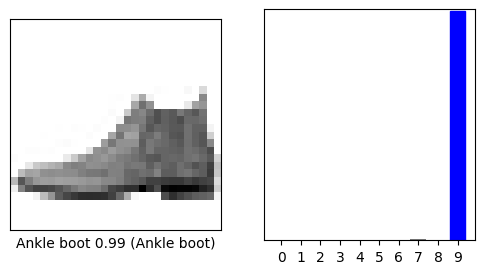

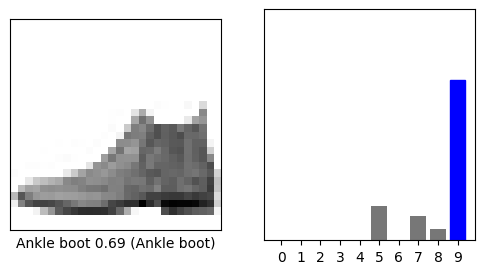

In [12]:
shifts = [0, 2, 4]
shifted_test_image_0 = np.array(
    [np.roll(test_images[0], shift, axis=0) for shift in shifts]
)

for model in models:
    print(f"\nPlots for {model.name}")
    predict_and_plot(model.nn, shifted_test_image_0, test_labels[0])


# Model Evaluation on Shifted Test Sets

Ensure that we shift images in a correct direction:

In [13]:
np.max(np.abs(np.roll(test_images[0], 1, axis=0) - np.roll(test_images, 1, axis=1)[0]))

0.0

Shift the test set and evaluate the model:

In [14]:
shifts = [0, -2, 2, -4, 4]

for model in models:
    print(f"\nEvaluating {model.name}")
    for shift in shifts:
        shifted_test_images = np.roll(test_images, shift, axis=1)
        test_loss, test_acc = model.nn.evaluate(
            shifted_test_images, test_labels, verbose=0
        )
        print(f"shift = {shift}, accuracy = {test_acc}")



Evaluating simple_mlp
shift = 0, accuracy = 0.8575999736785889
shift = -2, accuracy = 0.6947000026702881
shift = 2, accuracy = 0.6471999883651733
shift = -4, accuracy = 0.48840001225471497
shift = 4, accuracy = 0.46709999442100525

Evaluating simple_cnn_3
shift = 0, accuracy = 0.8996000289916992
shift = -2, accuracy = 0.809499979019165
shift = 2, accuracy = 0.8033999800682068
shift = -4, accuracy = 0.6230999827384949
shift = 4, accuracy = 0.6330999732017517

Evaluating simple_cnn_5
shift = 0, accuracy = 0.9061999917030334
shift = -2, accuracy = 0.8047000169754028
shift = 2, accuracy = 0.814300000667572
shift = -4, accuracy = 0.567300021648407
shift = 4, accuracy = 0.6144999861717224

Evaluating mult_layer_cnn
shift = 0, accuracy = 0.902899980545044
shift = -2, accuracy = 0.8216999769210815
shift = 2, accuracy = 0.8532000184059143
shift = -4, accuracy = 0.6506999731063843
shift = 4, accuracy = 0.694100022315979
